## Prerequisites

In [1]:
# pip install PyMuPDF                    # (install PyMuPDF for extracting info from PDF files)
# pip install tika                       # (install tika for extracting paragraphs from PDF files)
# pip install spacy==2.2.0               # (install spacy for lemmatization)
# conda install gensim==3.8.3            # (intall gesim for topic modelling, make sure the version of gensim is 3.8.3 to support Mallet)
# pip install pyLDAvis                   # (install pyLDAvis for topic modelling visulisation)
# conda install -c conda-forge pyldavis  # (if you use aconda to install pyLADvis)

In [2]:
import pandas as pd
import numpy as np
import nltk; nltk.download('stopwords') 
from nltk.corpus import stopwords      # import stop words
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\suhao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import re
from pprint import pprint

# glob for extracting the directories of metadata
import glob

# PyMuPDF
import fitz

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Visualisation

import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

F:\Anaconda\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps



## Import pdf files, data wrangling and overview

In [4]:
# Extract the directories of the PDF files
pdf_dir = "D:\LEON\Business Analytics\Study\9. Business Project\ChunkAll"
pdf_files = glob.glob("%s/*.pdf" % pdf_dir)
pdf_files[3]

'D:\\LEON\\Business Analytics\\Study\\9. Business Project\\ChunkAll\\10-1108_JOEPP-01-2014-0005.pdf'

In [5]:
# Use PyMuPDF to extract all info of the PDF files (text, title, date, etc)
list_metadata = []
for i in pdf_files:
    with fitz.open(i) as doc:
        info = doc.metadata       
        text = ''
        for page in doc:
            text+= page.getText()
        info['Content'] = text
    list_metadata.append(info)

In [6]:
df = pd.DataFrame(list_metadata)
df.head(3)

format                             title author subject keywords  \
0  PDF 1.3  EMERALD_JOEPP_JOEPP555623 56..76                           
1  PDF 1.3  EMERALD_JOEPP_JOEPP555624 35..55                           
2  PDF 1.3   EMERALD_JOEPP_JOEPP555625 2..13                           

                                        creator  \
0  Arbortext Advanced Print Publisher 9.0.226/W   
1  Arbortext Advanced Print Publisher 9.0.226/W   
2  Arbortext Advanced Print Publisher 9.0.226/W   

                            producer             creationDate  \
0  Acrobat Distiller 8.1.0 (Windows)  D:20140314203226+05'30'   
1  Acrobat Distiller 8.1.0 (Windows)  D:20140314222501+05'30'   
2  Acrobat Distiller 8.1.0 (Windows)  D:20140314192912+05'30'   

                   modDate trapped encryption  \
0        D:20140318130639Z               None   
1  D:20140314222501+05'30'               None   
2  D:20140314192912+05'30'               None   

                                             Content  
0  In the eyes of Janus\nThe intellectual structu...  
1  Human resource management and\norganizational ...  
2  Organizational effectiveness,\npeople and perf...

In [67]:
print(df.loc[0, 'Content']) # content of the first document

In the eyes of Janus
The intellectual structure of HRM-performance
debate and its future prospects
Robert Kasˇe
Faculty of Economics, University of Ljubljani, Ljubljana, Slovenia
Jaap Paauwe
Department of Human Resource Studies, Tilburg University, Tilburg,
The Netherlands, and
Sasˇa Batisticˇ
Henley Business School, University of Reading, Reading, UK
Abstract
Purpose – The purpose of this paper is to offer a perspective on the future of the human resource
management (HRM)-performance debate and its prospects for interaction with practice by evaluating
the debate’s intellectual structure.
Design/methodology/approach – With co-citation analysis the paper examines the intellectual
structure that informed the HRM-performance debate. The findings were presented to a group
of academics, who have been influential in the development of the debate. In several rounds of
a quasi-Delphi interaction they discussed the state of the art, future development of the debate,
upcoming theoretical sources

In [8]:
df = df.drop_duplicates(subset = 'Content') # drop duplicate rows
df = df.dropna(subset=['Content']) # drop NaNs
df['Word_count'] = df ['Content'].str.count(' ') + 1
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 0 to 158
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   format        154 non-null    object
 1   title         154 non-null    object
 2   author        154 non-null    object
 3   subject       154 non-null    object
 4   keywords      154 non-null    object
 5   creator       154 non-null    object
 6   producer      154 non-null    object
 7   creationDate  154 non-null    object
 8   modDate       154 non-null    object
 9   trapped       154 non-null    object
 10  encryption    0 non-null      object
 11  Content       154 non-null    object
 12  Word_count    154 non-null    int64 
dtypes: int64(1), object(12)
memory usage: 16.8+ KB


#### Word count

In [9]:
# Word count
df['Word_count'].sum( )

1306623

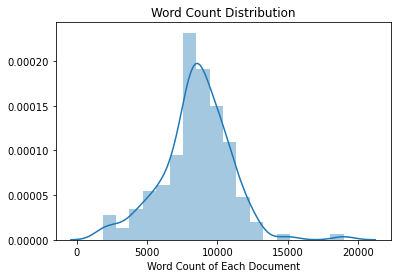

In [10]:
# Word count distribution
import seaborn as sns
ax1 = sns.distplot(df['Word_count'])
ax1.set(title = 'Word Count Distribution',
        xlabel = 'Word Count of Each Document');

## Tokenization

In [11]:
data = df.Content.values.tolist()

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
data_words[:1]

[['in',
  'the',
  'eyes',
  'of',
  'janus',
  'the',
  'intellectual',
  'structure',
  'of',
  'hrm',
  'performance',
  'debate',
  'and',
  'its',
  'future',
  'prospects',
  'robert',
  'kasˇe',
  'faculty',
  'of',
  'economics',
  'university',
  'of',
  'ljubljani',
  'ljubljana',
  'slovenia',
  'jaap',
  'paauwe',
  'department',
  'of',
  'human',
  'resource',
  'studies',
  'tilburg',
  'university',
  'tilburg',
  'the',
  'netherlands',
  'and',
  'sasˇa',
  'batisticˇ',
  'henley',
  'business',
  'school',
  'university',
  'of',
  'reading',
  'reading',
  'uk',
  'abstract',
  'purpose',
  'the',
  'purpose',
  'of',
  'this',
  'paper',
  'is',
  'to',
  'offer',
  'perspective',
  'on',
  'the',
  'future',
  'of',
  'the',
  'human',
  'resource',
  'management',
  'hrm',
  'performance',
  'debate',
  'and',
  'its',
  'prospects',
  'for',
  'interaction',
  'with',
  'practice',
  'by',
  'evaluating',
  'the',
  'debate',
  'intellectual',
  'structure',
  '

## Bigram and trigram

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['in', 'the', 'eyes', 'of', 'janus', 'the', 'intellectual_structure', 'of', 'hrm', 'performance', 'debate', 'and', 'its', 'future', 'prospects', 'robert', 'kasˇe', 'faculty', 'of', 'economics', 'university', 'of', 'ljubljani', 'ljubljana', 'slovenia', 'jaap', 'paauwe', 'department', 'of', 'human', 'resource', 'studies', 'tilburg_university_tilburg', 'the', 'netherlands', 'and', 'sasˇa', 'batisticˇ', 'henley', 'business', 'school', 'university', 'of', 'reading', 'reading', 'uk_abstract_purpose', 'the', 'purpose', 'of', 'this', 'paper', 'is', 'to', 'offer', 'perspective', 'on', 'the', 'future', 'of', 'the', 'human', 'resource', 'management', 'hrm', 'performance', 'debate', 'and', 'its', 'prospects', 'for', 'interaction', 'with', 'practice', 'by', 'evaluating', 'the', 'debate_intellectual_structure', 'design_methodology_approach', 'with', 'co_citation', 'analysis', 'the', 'paper', 'examines', 'the', 'intellectual_structure', 'that', 'informed', 'the', 'hrm', 'performance', 'debate', 'the'

## Remove Stopwords, Make Bigrams and Trigrams, and Lemmatisation

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['eye', 'performance', 'debate', 'future', 'prospect', 'reading', 'read', 'purpose', 'purpose', 'paper', 'offer', 'perspective', 'future', 'human', 'resource', 'management', 'performance', 'debate', 'prospect', 'interaction', 'practice', 'evaluate', 'debate', 'approach', 'analysis', 'paper', 'examine', 'intellectual_structure', 'inform', 'performance', 'debate', 'finding', 'present', 'group', 'influential', 'development', 'debate', 'several', 'round', 'discuss', 'state', 'art', 'future', 'development', 'debate', 'upcoming', 'theoretical', 'source', 'inspiration', 'topic', 'agree', 'finding', 'dominant', 'knowledge', 'domain', 'build', 'resource', 'base', 'exchange', 'human', 'capital', 'theory', 'institutional', 'theory', 'critical', 'perspective', 'become', 'well', 'establish', 'mid', 'strategic', 'domain', 'merge', 'high', 'performance', 'work', 'system', 'domain', 'thus', 'form', 'conceptual', 'backbone', 'debate', 'recently', 'debate', 'inform', 'review', 'study', 'meta_analyse', 

##  Create the Dictionary and Corpus needed for Topic Modeling

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 4), (2, 1), (3, 2), (4, 1), (5, 10), (6, 1), (7, 1), (8, 4), (9, 1), (10, 6), (11, 1), (12, 3), (13, 1), (14, 1), (15, 3), (16, 2), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (23, 3), (24, 1), (25, 4), (26, 1), (27, 1), (28, 1), (29, 1), (30, 3), (31, 2), (32, 1), (33, 1), (34, 1), (35, 4), (36, 1), (37, 7), (38, 4), (39, 1), (40, 2), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 34), (49, 7), (50, 1), (51, 1), (52, 20), (53, 2), (54, 1), (55, 1), (56, 2), (57, 3), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 4), (64, 1), (65, 3), (66, 6), (67, 2), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 6), (74, 11), (75, 1), (76, 11), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 2), (83, 9), (84, 3), (85, 1), (86, 1), (87, 2), (88, 1), (89, 3), (90, 2), (91, 1), (92, 1), (93, 1), (94, 2), (95, 2), (96, 7), (97, 3), (98, 12), (99, 2), (100, 1), (101, 1), (102, 10), (103, 4), (104, 1), (105, 2), (106, 3), (107, 2), (108, 2), (109, 5), (

## Building Mallet's LDA 

Download the zip file http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip, unzip it on the C drive

In [17]:
import os
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'})

In [18]:
mallet_path = 'C:/mallet-2.0.8/bin/mallet' # update this path,remove ""Read only" permission of the folder after unzipping.unzip- > Right click on "mallet-2.0.8" -> Uncheck "Read only"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [19]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.37863372849897214


#### Hyperameter tuning: tuning the number of topics to increase Coherence Score

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

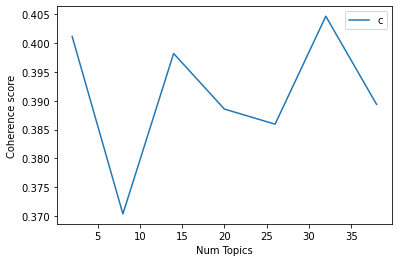

In [22]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4011
Num Topics = 8  has Coherence Value of 0.3704
Num Topics = 14  has Coherence Value of 0.3982
Num Topics = 20  has Coherence Value of 0.3886
Num Topics = 26  has Coherence Value of 0.3859
Num Topics = 32  has Coherence Value of 0.4046
Num Topics = 38  has Coherence Value of 0.3894


In [24]:
# Select the optimal model whose number of topics = 32
optimal_model = model_list[5]

In [25]:
lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model) # convert the mallet LDA model into a Gensim LDA model

## Visualisation

In [26]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, sort_topics = False )
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.132545 -0.025235       1        1   1.514381
1     -0.006713 -0.054245       2        1   4.529566
2     -0.210624  0.095317       3        1   1.937594
3      0.053467 -0.163234       4        1   2.035206
4     -0.147821 -0.039093       5        1   2.463908
5      0.144817 -0.069905       6        1  11.062105
6      0.034298  0.225174       7        1   1.457861
7      0.024962 -0.212293       8        1   3.330264
8     -0.098153 -0.021224       9        1  11.607832
9     -0.147551 -0.042766      10        1   4.267286
10    -0.131556  0.028238      11        1   2.045817
11     0.059169 -0.157639      12        1   1.850345
12    -0.167672 -0.029286      13        1   2.067933
13    -0.140509  0.110647      14        1   3.077538
14    -0.047748 -0.059016      15        1   4.954074
15    -0.004834 -0.063326      16        1   2.080617
16     0.193686  0.123279      17        1   3.401613
17     0.115850  0.115026      18        1   1.827186
18     0.093341 -0.034757      19        1   2.978953
19     0.119577  0.005831      20        1   1.519208
20     0.110831  0.130601      21        1   2.368103
21    -0.176036  0.005358      22        1   1.832828
22    -0.169357  0.053308      23        1   2.095477
23     0.075011  0.076591      24        1   1.921343
24     0.021173 -0.123377      25        1   1.905170
25    -0.002174 -0.041558      26        1   3.006216
26    -0.041481 -0.066000      27        1   3.421507
27     0.028762  0.061680      28        1   1.618961
28     0.020378  0.137493      29        1   2.191399
29     0.194719 -0.033546      30        1   4.635849
30     0.039127  0.072996      31        1   2.171960
31     0.030516 -0.005038      32        1   2.821900, topic_info=                Term         Freq        Total Category  logprob  loglift
355         employee  7990.000000  7990.000000  Default  30.0000  30.0000
579              job  4404.000000  4404.000000  Default  29.0000  29.0000
1175            work  7041.000000  7041.000000  Default  28.0000  28.0000
737   organizational  5709.000000  5709.000000  Default  27.0000  27.0000
778      performance  6156.000000  6156.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
800         positive   111.696137  1587.991258  Topic32  -5.0288   0.9133
746          outcome   104.030716  1962.759209  Topic32  -5.0999   0.6303
736     organization   110.601077  4187.380216  Topic32  -5.0386  -0.0661
31            affect    93.080114   785.012253  Topic32  -5.2111   1.4355
338           effect    90.889994  2477.492231  Topic32  -5.2349   0.2624

[3015 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
8269      13  0.910051   aaltonen
7891      27  0.913120  abilities
0          1  0.015498    ability
0          9  0.139478    ability
0         10  0.116232    ability
...      ...       ...        ...
1902      29  0.894252    younger
6687      20  0.980189      youth
2186      22  0.903876    zammuto
10706     29  1.073102   ﬁnancial
8727      27  0.913120        ﬁrm

[6870 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

#### The most frequent 10 words of each topic

In [27]:
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(31,
  '0.075*"employee" + 0.052*"trust" + 0.051*"change" + 0.029*"process" + '
  '0.023*"manager" + 0.021*"performance" + 0.019*"relationship" + '
  '0.015*"study" + 0.015*"level" + 0.014*"management"'),
 (25,
  '0.055*"research" + 0.034*"group" + 0.031*"network" + 0.019*"author" + '
  '0.014*"field" + 0.013*"debate" + 0.013*"analysis" + 0.012*"level" + '
  '0.010*"social" + 0.009*"study"'),
 (6,
  '0.048*"agency" + 0.042*"work" + 0.036*"worker" + 0.028*"firm" + '
  '0.022*"employment" + 0.018*"identity" + 0.017*"taw" + 0.016*"sector" + '
  '0.016*"social" + 0.015*"temporary"'),
 (28,
  '0.046*"firm" + 0.043*"work" + 0.042*"time" + 0.037*"part" + '
  '0.024*"employment" + 0.023*"institutional" + 0.018*"local" + '
  '0.015*"relationship" + 0.013*"employee" + 0.012*"context"'),
 (17,
  '0.045*"employee" + 0.034*"job" + 0.031*"insecurity" + 0.027*"work" + '
  '0.026*"age" + 0.022*"employer" + 0.016*"image" + 0.013*"brand" + '
  '0.013*"organization" + 0.012*"economic"'),
 (9,
  '0.046*"

In [28]:
texts

[['eye',
  'performance',
  'debate',
  'future',
  'prospect',
  'reading',
  'read',
  'purpose',
  'purpose',
  'paper',
  'offer',
  'perspective',
  'future',
  'human',
  'resource',
  'management',
  'performance',
  'debate',
  'prospect',
  'interaction',
  'practice',
  'evaluate',
  'debate',
  'approach',
  'analysis',
  'paper',
  'examine',
  'intellectual_structure',
  'inform',
  'performance',
  'debate',
  'finding',
  'present',
  'group',
  'influential',
  'development',
  'debate',
  'several',
  'round',
  'discuss',
  'state',
  'art',
  'future',
  'development',
  'debate',
  'upcoming',
  'theoretical',
  'source',
  'inspiration',
  'topic',
  'agree',
  'finding',
  'dominant',
  'knowledge',
  'domain',
  'build',
  'resource',
  'base',
  'exchange',
  'human',
  'capital',
  'theory',
  'institutional',
  'theory',
  'critical',
  'perspective',
  'become',
  'well',
  'establish',
  'mid',
  'strategic',
  'domain',
  'merge',
  'high',
  'performance',

#### Dominant topic in each document

In [29]:
# topic distribution of each document
for d in texts:
    bow = id2word.doc2bow(d)
    belong = lda_model[bow]
    print(belong)

[(1, 0.047294533134965996), (4, 0.019680427801593705), (5, 0.02758072462266055), (7, 0.03664292688872511), (8, 0.20431508099070286), (9, 0.043602101561922235), (14, 0.21444058138661778), (21, 0.010738901011612208), (25, 0.28289863211878197), (26, 0.029160406544526042), (28, 0.014494847527372779)]
[(1, 0.03645354020401548), (8, 0.18497529857228748), (9, 0.33888770247009176), (10, 0.035039819542116886), (12, 0.017439379512819684), (13, 0.013097147117099264), (14, 0.13074020906926806), (15, 0.01206323177881427), (17, 0.02038406606210206), (21, 0.010578089640017928), (26, 0.021457969264984986), (28, 0.06340486715840432), (29, 0.010687737582007587), (30, 0.016110325776288407), (31, 0.010262811162495701)]
[(2, 0.027222186061200027), (4, 0.045800161211992985), (7, 0.14299328129152825), (8, 0.2623931014156237), (9, 0.11288776840065118), (13, 0.02506234532866332), (14, 0.1248507718499928), (20, 0.012363435058126334), (21, 0.041158205926639206), (22, 0.014373208527365948), (24, 0.027226418663464

In [30]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 4), (2, 1), (3, 2), (4, 1), (5, 10), (6, 1), (7, 1), (8, 4), (9, 1), (10, 6), (11, 1), (12, 3), (13, 1), (14, 1), (15, 3), (16, 2), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (23, 3), (24, 1), (25, 4), (26, 1), (27, 1), (28, 1), (29, 1), (30, 3), (31, 2), (32, 1), (33, 1), (34, 1), (35, 4), (36, 1), (37, 7), (38, 4), (39, 1), (40, 2), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 34), (49, 7), (50, 1), (51, 1), (52, 20), (53, 2), (54, 1), (55, 1), (56, 2), (57, 3), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 4), (64, 1), (65, 3), (66, 6), (67, 2), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 6), (74, 11), (75, 1), (76, 11), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 2), (83, 9), (84, 3), (85, 1), (86, 1), (87, 2), (88, 1), (89, 3), (90, 2), (91, 1), (92, 1), (93, 1), (94, 2), (95, 2), (96, 7), (97, 3), (98, 12), (99, 2), (100, 1), (101, 1), (102, 10), (103, 4), (104, 1), (105, 2), (106, 3), (107, 2), (108, 2), (109, 5), (

In [31]:
texts

[['eye',
  'performance',
  'debate',
  'future',
  'prospect',
  'reading',
  'read',
  'purpose',
  'purpose',
  'paper',
  'offer',
  'perspective',
  'future',
  'human',
  'resource',
  'management',
  'performance',
  'debate',
  'prospect',
  'interaction',
  'practice',
  'evaluate',
  'debate',
  'approach',
  'analysis',
  'paper',
  'examine',
  'intellectual_structure',
  'inform',
  'performance',
  'debate',
  'finding',
  'present',
  'group',
  'influential',
  'development',
  'debate',
  'several',
  'round',
  'discuss',
  'state',
  'art',
  'future',
  'development',
  'debate',
  'upcoming',
  'theoretical',
  'source',
  'inspiration',
  'topic',
  'agree',
  'finding',
  'dominant',
  'knowledge',
  'domain',
  'build',
  'resource',
  'base',
  'exchange',
  'human',
  'capital',
  'theory',
  'institutional',
  'theory',
  'critical',
  'perspective',
  'become',
  'well',
  'establish',
  'mid',
  'strategic',
  'domain',
  'merge',
  'high',
  'performance',

In [32]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_Number', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

Document_Number  Dominant_Topic  Topic_Perc_Contrib  \
0                  0            25.0              0.2856   
1                  1             9.0              0.3380   
2                  2             8.0              0.2649   
3                  3             2.0              0.2600   
4                  4            16.0              0.3425   
..               ...             ...                 ...   
149              149            10.0              0.4046   
150              150            20.0              0.2699   
151              151            10.0              0.3239   
152              152            31.0              0.3256   
153              153            19.0              0.2994   

                                              Keywords  \
0    research, group, network, author, field, debat...   
1    knowledge, organization, organizational, proce...   
2    performance, management, approach, include, ev...   
3    risk, management, firm, role, sale, technology...   
4    workplace, employee, work, job, demand, psycho...   
..                                                 ...   
149  firm, business, growth, family, sme, small, ma...   
150  organisation, organisational, employee, work, ...   
151  firm, business, growth, family, sme, small, ma...   
152  employee, trust, change, process, manager, per...   
153  life, positive, resilience, satisfaction, emot...   

                                                  Text  
0    In the eyes of Janus\nThe intellectual structu...  
1    Human resource management and\norganizational ...  
2    Organizational effectiveness,\npeople and perf...  
3    HR strategy: optimizing risks,\noptimizing rew...  
4    No accident: health, well-being,\nperformance ...  
..                                                 ...  
149  Impact of cultural intelligence\non SME perfor...  
150  Different strokes for\ndifferent folks\nGroup ...  
151  Supporting SMEs’\ninternationalisation through...  
152  Knowledge-sharing mechanisms:\nhuman resource ...  
153  Subclinical psychopathy,\ninterpersonal workpl...  

[154 rows x 5 columns]

#### The most representative document for each topic¶

In [33]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')



for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(5)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.7202   
1        1.0              0.5403   
2        2.0              0.4636   
3        3.0              0.4292   
4        4.0              0.5545   

                                            Keywords  \
0  personality, facet, performance, factor, openn...   
1  research, analysis, study, question, datum, in...   
2  risk, management, firm, role, sale, technology...   
3  leadership, leader, safety, follower, performa...   
4  analytic, people, datum, business, team, hr, o...   

                                                Text  
0  Sifting the Big Five: examining\nthe criterion...  
1  Using online data and\nnetwork-based text anal...  
2  Risk and organizational\neffectiveness\nThe ro...  
3  Are leaders defined by\nfollowers? Role of fol...  
4  People analytics effectiveness:\ndeveloping a ...

# Apply the trained model to predict the topics of paragraphs

#### Extract paragraphs from documents

In [34]:
import tika               # import tika for text extraction from documents
from tika import parser   

In [113]:
# create the function for metadata extraction from documents
def info(i):
    with fitz.open (i) as doc:
        info = doc.metadata
        return info

In [114]:
# create the function for paragraph extraction from documents
def paragraphs_extraction(i):
    j = parser.from_file(i)
    m = j['content']
    n = m.split('\n\n')                     # split the documents by new lines
    n = [w.replace('\n', ' ') for w in n]
    return n

In [166]:
list_paragraphs = []
for i in pdf_files:
    with fitz.open(i) as doc:
        info = doc.metadata
        info['paragraphs'] = paragraphs_extraction(i) 
    list_paragraphs.append(info)                      # if it fails, try to rerun it
df_para = pd.DataFrame(list_paragraphs) # dataframe containing paragraphs of each documents

In [193]:
# split the list of paragraphs into rows
df_paragraph  = df_para.set_index(['title'])['paragraphs'].apply(pd.Series)\
                                         .stack()\
                                         .reset_index(level=1, drop=True)
df_paragraph = df_paragraph.reset_index()
df_paragraph.columns = ['title', 'paragraphs']
df_paragraph['paragraphs'] = [w.replace('\t', '') for w in df_paragraph['paragraphs']]
df_paragraph

title  \
0      EMERALD_JOEPP_JOEPP555623 56..76   
1      EMERALD_JOEPP_JOEPP555623 56..76   
2      EMERALD_JOEPP_JOEPP555623 56..76   
3      EMERALD_JOEPP_JOEPP555623 56..76   
4      EMERALD_JOEPP_JOEPP555623 56..76   
...                                 ...   
64322   JOEPP-12-2019-0120_proof 44..58   
64323   JOEPP-12-2019-0120_proof 44..58   
64324   JOEPP-12-2019-0120_proof 44..58   
64325   JOEPP-12-2019-0120_proof 44..58   
64326   JOEPP-12-2019-0120_proof 44..58   

                                              paragraphs  
0                                                         
1                                                         
2                                                         
3                                                         
4                                                         
...                                                  ...  
64322   Method and analysis Findings Theme 1: Subclin...  
64323  Discussion Practical implications Limitations ...  
64324                        Concluding comments Summary  
64325                         References Further reading  
64326                                                     

[64327 rows x 2 columns]

In [194]:
df_paragraph.loc[643, 'paragraphs']

'Our reading of the literature since 1987 indicates that all of the components shown in Figure 1 are now being considered as essential to an understanding of HRM and OE ( Jackson et al., 2014; Guerci and Shani, 2013), and reflect parallel developments in the broad domain of strategic management (Ireland, 2013). Thus, today’s more comprehensive model of HRM and OE includes elements of the external global environment, the internal organizational environment, the HRM system and multiple stakeholders. We organize our discussion around these components and highlight the richness of the relationship between HRM and OE we experience today, and what this means for the HRM field.'

#### Predict topics of paragraphs

In [215]:
# create function for topic extraction
def topic_extraction(i):
    doc = i.split()
    doc_vector = lda_model.id2word.doc2bow(doc)
    doc_topics = lda_model[doc_vector]
    return doc_topics

In [216]:
list_topic = []
for i in df_paragraph['paragraphs']:
    doc = i.split()
    doc_vector = lda_model.id2word.doc2bow(doc)
    doc_topics = lda_model[doc_vector]
    list_topic.append(doc_topics)
df_paragraph['topic_distribution'] = list_topic 

In [217]:
df_paragraph # topic distribution of each topic

title  \
0      EMERALD_JOEPP_JOEPP555623 56..76   
1      EMERALD_JOEPP_JOEPP555623 56..76   
2      EMERALD_JOEPP_JOEPP555623 56..76   
3      EMERALD_JOEPP_JOEPP555623 56..76   
4      EMERALD_JOEPP_JOEPP555623 56..76   
...                                 ...   
64322   JOEPP-12-2019-0120_proof 44..58   
64323   JOEPP-12-2019-0120_proof 44..58   
64324   JOEPP-12-2019-0120_proof 44..58   
64325   JOEPP-12-2019-0120_proof 44..58   
64326   JOEPP-12-2019-0120_proof 44..58   

                                              paragraphs  \
0                                                          
1                                                          
2                                                          
3                                                          
4                                                          
...                                                  ...   
64322   Method and analysis Findings Theme 1: Subclin...   
64323  Discussion Practical implications Limitations ...   
64324                        Concluding comments Summary   
64325                         References Further reading   
64326                                                      

                                      topic_distribution  
0      [(0, 0.03125), (1, 0.03125), (2, 0.03125), (3,...  
1      [(0, 0.03125), (1, 0.03125), (2, 0.03125), (3,...  
2      [(0, 0.03125), (1, 0.03125), (2, 0.03125), (3,...  
3      [(0, 0.03125), (1, 0.03125), (2, 0.03125), (3,...  
4      [(0, 0.03125), (1, 0.03125), (2, 0.03125), (3,...  
...                                                  ...  
64322  [(0, 0.026691023593149826), (1, 0.033336103100...  
64323  [(0, 0.030048324309937664), (1, 0.029481132075...  
64324  [(0, 0.03063725490210167), (1, 0.0502450980348...  
64325  [(0, 0.030637254901965602), (1, 0.030637254901...  
64326  [(0, 0.03125), (1, 0.03125), (2, 0.03125), (3,...  

[64327 rows x 3 columns]

## Build topic model on paragraphs

In [231]:
# tokenization
data2 = df_paragraph.paragraphs.values.tolist()
data_words2 = list(sent_to_words(data2))

In [250]:
# Bigram & Trigram
bigram2 = gensim.models.Phrases(data_words2, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram2 = gensim.models.Phrases(bigram2[data_words2], threshold=100)  
bigram_mod2 = gensim.models.phrases.Phraser(bigram2)
trigram_mod2 = gensim.models.phrases.Phraser(trigram2)

In [251]:
# Remove Stop Words
data_words_nostops2 = remove_stopwords(data_words2)

# Form Bigrams
data_words_bigrams2 = make_bigrams(data_words_nostops2)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized2 = lemmatization(data_words_bigrams2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [252]:
# Create Dictionary
id2word2 = corpora.Dictionary(data_lemmatized2)

# Create Corpus
texts2 = data_lemmatized2

# Term Document Frequency
corpus2 = [id2word2.doc2bow(text) for text in texts]

In [261]:
# Gensim LDA model
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus2,
                                           id2word=id2word2,
                                           num_topics=30, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [262]:
# Compute Coherence Score
coherence_model_lda2 = CoherenceModel(model=lda_model2, texts=data_lemmatized2, dictionary=id2word2, coherence='c_v')
coherence_lda2 = coherence_model_lda2.get_coherence()
print('\nCoherence Score: ', coherence_lda2)


Coherence Score:  0.5603206656799674


In [263]:
# Visualize the topics
vis2 = pyLDAvis.gensim_models.prepare(lda_model2, corpus2, id2word2, sort_topics = False)
vis2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.276022 -0.034021       1        1   0.109431
1      0.279368  0.001891       2        1   0.000316
2     -0.219343 -0.086019       3        1  12.199314
3      0.135809  0.108350       4        1   0.414692
4      0.278987  0.001920       5        1   0.000321
5     -0.179289 -0.144547       6        1   2.309403
6      0.279070  0.001896       7        1   0.000317
7     -0.211789  0.041659       8        1  12.271849
8     -0.177417  0.107877       9        1   6.149687
9     -0.207411 -0.037550      10        1   3.359035
10    -0.154280  0.051187      11        1   1.892156
11    -0.113253  0.157892      12        1   1.792343
12    -0.188302 -0.040846      13        1   3.903073
13    -0.183469  0.081493      14        1   3.530872
14     0.165818 -0.023837      15        1   0.222560
15     0.244207 -0.030438      16        1   0.101931
16     0.174647 -0.043054      17        1   0.263091
17    -0.151222  0.089919      18        1  17.358555
18    -0.028897 -0.026893      19        1   0.909234
19     0.002183 -0.015705      20        1   0.730853
20     0.279167  0.001838      21        1   0.000319
21    -0.196467  0.117610      22        1   3.042280
22     0.279181  0.001917      23        1   0.000320
23    -0.142725 -0.195715      24        1   1.647331
24     0.283570  0.013408      25        1   0.133708
25     0.280833  0.002223      26        1   0.053002
26    -0.212641 -0.104537      27        1  10.121036
27    -0.166863  0.036957      28        1   7.087853
28    -0.201721 -0.040617      29        1   4.745136
29    -0.223772  0.005743      30        1   5.649984, topic_info=              Term         Freq        Total Category  logprob  loglift
89            work  6357.000000  6357.000000  Default  30.0000  30.0000
799            job  3941.000000  3941.000000  Default  29.0000  29.0000
1869    engagement  1513.000000  1513.000000  Default  28.0000  28.0000
466       employee  7593.000000  7593.000000  Default  27.0000  27.0000
1      performance  6107.000000  6107.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
69    relationship   195.937985  2874.942144  Topic30  -5.1595   0.1875
294         result   170.530614  2048.910665  Topic30  -5.2984   0.3874
98          effect   169.886467  2243.049499  Topic30  -5.3022   0.2931
466       employee   190.582477  7593.083922  Topic30  -5.1872  -0.8114
137           also   170.519766  2723.554019  Topic30  -5.2984   0.1027

[2212 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
10245     19  0.788468     aalber
8033      16  0.307967  abilities
8033      18  0.615934  abilities
551        3  0.056466    ability
551        6  0.042777    ability
...      ...       ...        ...
11269     17  0.483946       yoga
8038      30  0.977410     youndt
10379      1  0.467510      youne
6596       1  0.749714      youth
6596      27  0.149943      youth

[7049 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

#### The most frequent 10 words of each topic

In [264]:
model_topics2 = lda_model2.show_topics(formatted=False)
pprint(lda_model2.print_topics(num_words=10))

[(6,
  '0.000*"work" + 0.000*"organizational" + 0.000*"employee" + '
  '0.000*"performance" + 0.000*"organization" + 0.000*"may" + '
  '0.000*"management" + 0.000*"talent" + 0.000*"research" + 0.000*"use"'),
 (1,
  '0.000*"employee" + 0.000*"work" + 0.000*"organization" + '
  '0.000*"performance" + 0.000*"organizational" + 0.000*"research" + '
  '0.000*"use" + 0.000*"resource" + 0.000*"practice" + 0.000*"knowledge"'),
 (20,
  '0.000*"organizational" + 0.000*"employee" + 0.000*"resource" + '
  '0.000*"organization" + 0.000*"work" + 0.000*"job" + 0.000*"management" + '
  '0.000*"engagement" + 0.000*"may" + 0.000*"performance"'),
 (4,
  '0.000*"employee" + 0.000*"performance" + 0.000*"management" + '
  '0.000*"organizational" + 0.000*"use" + 0.000*"organization" + 0.000*"study" '
  '+ 0.000*"research" + 0.000*"work" + 0.000*"talent"'),
 (22,
  '0.000*"organizational" + 0.000*"employee" + 0.000*"research" + '
  '0.000*"practice" + 0.000*"performance" + 0.000*"work" + 0.000*"firm" + '
  '0.